In [1]:
import pandas as pd
import numpy as np
import random
import itertools

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline


**Các hàm**

In [2]:
def outlier_handling(X_train, X_test, variable, dist='gaussian'):
        if dist=='gaussian':
            uppper_boundary=int(X_train[variable].mean()+3*X_train[variable].std())
            lower_boundary=int(X_train[variable].mean()-3*X_train[variable].std())
            X_train.loc[X_train[variable]>uppper_boundary,variable]=uppper_boundary
            X_test.loc[X_test[variable]>uppper_boundary,variable]=uppper_boundary
        elif dist=='skewed':
            IQR = X_train[variable].quantile(0.75) - X_train[variable].quantile(0.25)
            upper_bridge = int(X_train[variable].quantile(0.75) + (IQR * 3))
            lower_bridge = int(X_train[variable].quantile(0.25) - (IQR * 3))
            X_train.loc[X_train[variable]>upper_bridge,variable]=upper_bridge
            X_test.loc[X_test[variable]>upper_bridge,variable]=upper_bridge
        else:
            pass
        return X_train, X_test

def fit_transform(X, method='Normalizer'):
        if method == 'Normalizer':
            return Normalizer().fit_transform(X)
        else:
            return X

def feature_selection_method(X, y, method='SelectKBest'):
        if method == 'SelectKBest':
            return RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1), SelectKBest(f_classif, k=9).fit_transform(X, y)
        elif method == 'VarianceThreshold':
            return RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1), VarianceThreshold(0.25).fit_transform(X)
        else:
            return RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1), X


In [3]:
matches = pd.read_csv("D:\\Data\\1000_clean_data.csv", index_col=0)

In [4]:
matches["date"] = pd.to_datetime(matches["date"])

In [5]:
matches

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,fk,pk,pkatt,season,team,target,venue_code,opp_code,hour,day_code
1,2022-08-07,16:30,Premier League,Matchweek 1,Sun,Away,W,2.0,0.0,West Ham,...,1.0,1.0,1.0,2023,Manchester City,1,0,21,16,6
2,2022-08-13,15:00,Premier League,Matchweek 2,Sat,Home,W,4.0,0.0,Bournemouth,...,0.0,0.0,0.0,2023,Manchester City,1,1,2,15,5
3,2022-08-21,16:30,Premier League,Matchweek 3,Sun,Away,D,3.0,3.0,Newcastle Utd,...,1.0,0.0,0.0,2023,Manchester City,0,0,15,16,6
4,2022-08-27,15:00,Premier League,Matchweek 4,Sat,Home,W,4.0,2.0,Crystal Palace,...,0.0,0.0,0.0,2023,Manchester City,1,1,7,15,5
5,2022-08-31,19:30,Premier League,Matchweek 5,Wed,Home,W,6.0,0.0,Nott'ham Forest,...,0.0,0.0,0.0,2023,Manchester City,1,1,17,19,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,2022-04-30,15:00,Premier League,Matchweek 35,Sat,Away,L,0.0,2.0,Aston Villa,...,0.0,0.0,0.0,2022,Norwich City,0,0,1,15,5
39,2022-05-08,14:00,Premier League,Matchweek 36,Sun,Home,L,0.0,4.0,West Ham,...,1.0,0.0,0.0,2022,Norwich City,0,1,21,14,6
40,2022-05-11,19:45,Premier League,Matchweek 21,Wed,Away,L,0.0,3.0,Leicester City,...,0.0,0.0,0.0,2022,Norwich City,0,0,11,19,2
41,2022-05-15,14:00,Premier League,Matchweek 37,Sun,Away,D,1.0,1.0,Wolves,...,0.0,0.0,0.0,2022,Norwich City,0,0,22,14,6


In [6]:
so_mau = len(matches)

# Số đặc trưng của 1 mẫu
so_dac_trung = matches.shape[1]

# Kiểu dữ liệu của mỗi đặc trưng
kieu_du_lieu = matches.dtypes

# Số mẫu dữ liệu trống của mỗi đặc trưng
so_mau_trong = matches.isnull().sum()
df_thong_ke = pd.DataFrame({
    'So_Mau': so_mau,
    'Kieu_Du_Lieu': kieu_du_lieu,
    'So_Gia_Tri_Null': so_mau_trong
})
df_thong_ke

,So_Mau,Kieu_Du_Lieu,So_Gia_Tri_Null
date,1496,datetime64[ns],0
time,1496,object,0
comp,1496,object,0
round,1496,object,0
day,1496,object,0
venue,1496,object,0
result,1496,object,0
gf,1496,float64,0
ga,1496,float64,0
opponent,1496,object,0


### Thêm các đặc trưng phong độ hiện tại của đội bóng

In [7]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(6, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [8]:
cols = ["gf", "ga","poss", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))

In [9]:
matches_rolling = matches_rolling.droplevel('team')

In [10]:
matches_rolling.index = range(matches_rolling.shape[0])

In [11]:
matches_rolling

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,day_code,gf_rolling,ga_rolling,poss_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
0,2021-10-02,17:30,Premier League,Matchweek 7,Sat,Away,D,0.0,0.0,Brighton,...,5,0.833333,1.666667,45.000000,14.000000,3.833333,16.633333,0.500000,0.000000,0.000000
1,2021-10-18,20:00,Premier League,Matchweek 8,Mon,Home,D,2.0,2.0,Crystal Palace,...,0,0.833333,1.333333,41.333333,11.666667,3.500000,16.983333,0.500000,0.000000,0.000000
2,2021-10-22,20:00,Premier League,Matchweek 9,Fri,Home,W,3.0,1.0,Aston Villa,...,4,1.166667,1.333333,44.500000,13.500000,4.000000,16.800000,0.666667,0.000000,0.000000
3,2021-10-30,12:30,Premier League,Matchweek 10,Sat,Away,W,2.0,0.0,Leicester City,...,5,1.666667,0.666667,50.000000,16.833333,5.333333,18.550000,0.833333,0.000000,0.166667
4,2021-11-07,14:00,Premier League,Matchweek 11,Sun,Home,W,1.0,0.0,Watford,...,6,1.833333,0.666667,47.500000,13.333333,5.166667,18.516667,0.666667,0.000000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,2023-04-25,19:30,Premier League,Matchweek 33,Tue,Home,W,2.0,0.0,Crystal Palace,...,1,1.333333,1.500000,56.500000,12.333333,4.833333,19.350000,0.666667,0.000000,0.000000
1354,2023-04-29,15:00,Premier League,Matchweek 34,Sat,Away,L,0.0,6.0,Brighton,...,5,1.500000,1.166667,53.833333,12.500000,4.500000,18.933333,0.500000,0.166667,0.166667
1355,2023-05-06,15:00,Premier League,Matchweek 35,Sat,Home,W,1.0,0.0,Aston Villa,...,5,1.166667,1.500000,50.166667,10.333333,3.500000,19.366667,0.333333,0.166667,0.166667
1356,2023-05-13,15:00,Premier League,Matchweek 36,Sat,Away,L,0.0,2.0,Manchester Utd,...,5,1.166667,1.333333,44.666667,10.000000,3.666667,19.433333,0.333333,0.166667,0.166667


In [12]:
# Lấy các đặc trưng quan tâm
features = ["venue_code", "opp_code", "hour", "day_code", "gf_rolling", "ga_rolling", "poss_rolling", "sh_rolling", "sot_rolling", "dist_rolling", "fk_rolling", "pk_rolling", "pkatt_rolling"]
X = matches_rolling[features]
y = matches_rolling['target']

### Sự tương quan giữa các đặc trưng và kết quả

In [13]:
corrs = []
for feature in features:
    corr = []
    for feature_1 in features:
        corr.append(np.corrcoef(X[feature], X[feature_1])[0][1])
    corrs.append(corr)

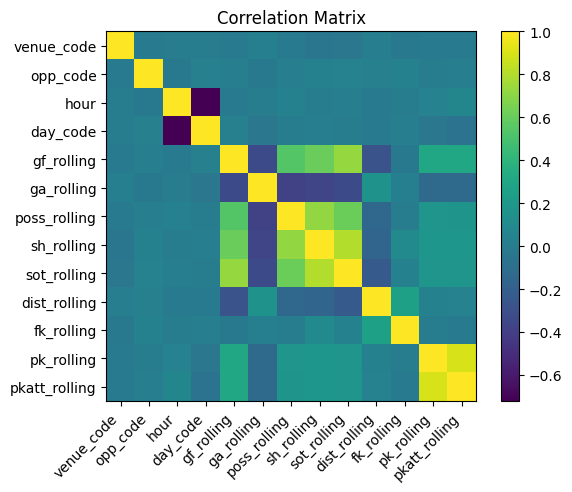

In [14]:
plt.imshow(corrs, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(features)), features)
plt.yticks(np.arange(len(features)), features)
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right')
plt.title('Correlation Matrix')
plt.show()

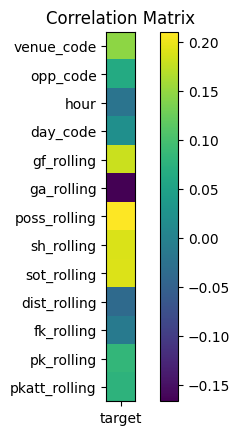

In [15]:
corrs = []
for feature in features:
    corrs.append(np.corrcoef(X[feature], y)[0][1])
plt.imshow(np.array(corrs).reshape(13,1), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(1), ["target"])
plt.yticks(np.arange(len(features)), features)
# plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right')
plt.title('Correlation Matrix')
plt.show()


### Tiến hành xử lí dữ liệu

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
X_train.head()

,venue_code,opp_code,hour,day_code,gf_rolling,ga_rolling,poss_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
328,1,8,19,2,0.333333,1.833333,36.166667,7.500000,1.500000,18.333333,0.333333,0.000000,0.000000
1042,0,1,15,5,1.000000,2.333333,43.333333,10.166667,3.666667,17.350000,0.000000,0.000000,0.166667
318,1,20,18,5,0.333333,1.166667,40.000000,8.833333,1.500000,17.933333,0.500000,0.000000,0.000000
1050,0,6,15,5,0.666667,1.166667,47.833333,12.333333,3.500000,18.483333,0.666667,0.166667,0.166667
83,0,8,12,5,1.333333,1.500000,46.666667,11.833333,4.166667,17.133333,0.166667,0.000000,0.000000


In [18]:
results = pd.DataFrame(columns=['Outlier_ga_rolling', 'Transform', 'Accuracy after 10 times'])
outlier_ga_rolling = ['none','gaussian','skewed']
transform = ['none']
combinations = list(itertools.product(outlier_ga_rolling, transform))
len(combinations)

3

In [19]:
for i in range(len(combinations)):
    type_outlier_ga_rolling, type_transform = combinations[i]
    accuracy = []
    print("{0} - {1}".format(i, combinations[i]))
    for j in range(0, 10):
        X = matches_rolling[features]
        y = matches_rolling["target"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=j)

        X_train, X_test = outlier_handling(X_train, X_test, "ga_rolling", type_outlier_ga_rolling)
        
        X_train = fit_transform(X_train, type_transform)
        X_test = fit_transform(X_test, type_transform)
        
        classifier=RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)
        classifier.fit(X_train, y_train)
        y_pred=classifier.predict(X_test)
        accuracy.append(accuracy_score(y_test,y_pred))
        
    result = {'Outlier_ga_rolling': type_outlier_ga_rolling, 'Transform': type_transform, 'Accuracy after 10 times': sum(accuracy)/len(accuracy)}
    results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)

0 - ('none', 'none')
1 - ('gaussian', 'none')
2 - ('skewed', 'none')


In [20]:
results

,Outlier_ga_rolling,Transform,Accuracy after 10 times
0,none,none,0.658333
1,gaussian,none,0.657843
2,skewed,none,0.658088


In [21]:
results['Accuracy after 10 times'].max()

0.6583333333333334

0.6583333333333334

In [22]:
results.query('`Accuracy after 10 times` == `Accuracy after 10 times`.max()')

,Outlier_ga_rolling,Transform,Accuracy after 10 times
0,none,none,0.658333


### Feature Selection

In [23]:
results = pd.DataFrame(columns=['Outlier_ga_rolling', 'Transform', 'Feature', 'Accuracy after 10 times'])
outlier_ga_rolling = ['none', 'gaussian']
transform = ['none']
feature_selections = ['SelectKBest', 'VarianceThreshold']
combinations = list(itertools.product(outlier_ga_rolling, transform, feature_selections))
len(combinations)

4

In [24]:
for i in range(len(combinations)):
    type_outlier_ga_rolling, type_transform, feature = combinations[i]
    accuracy = []
    print("{0} - {1}".format(i, combinations[i]))
    for j in range(0, 10):
        X_train = matches_rolling[features]
        y_train = matches_rolling["target"]

        X_train, nah = outlier_handling(X_train, X_train, "ga_rolling", type_outlier_ga_rolling)
        
        X_train = fit_transform(X_train, type_transform)
        
        classifier, X = feature_selection_method(X_train, y_train, feature)
        acc_log = cross_val_score(classifier, X, y_train, scoring = 'accuracy', cv = 5).mean()
        accuracy.append(acc_log)
        
    result = {'Outlier_ga_rolling': type_outlier_ga_rolling, 'Transform': type_transform, 'Feature': feature, 'Accuracy after 10 times': sum(accuracy)/len(accuracy)}
    results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)

0 - ('none', 'none', 'SelectKBest')
1 - ('none', 'none', 'VarianceThreshold')
2 - ('gaussian', 'none', 'SelectKBest')
3 - ('gaussian', 'none', 'VarianceThreshold')


In [25]:
results

,Outlier_ga_rolling,Transform,Feature,Accuracy after 10 times
0,none,none,SelectKBest,0.642142
1,none,none,VarianceThreshold,0.628883
2,gaussian,none,SelectKBest,0.641413
3,gaussian,none,VarianceThreshold,0.622976


In [26]:
results['Accuracy after 10 times'].max()

0.6421423920121555

0.642142392012155

In [27]:
X = matches_rolling[features]
y = matches_rolling["target"]

In [28]:
seed = 42
models = [
    RandomForestClassifier(random_state=seed),
]

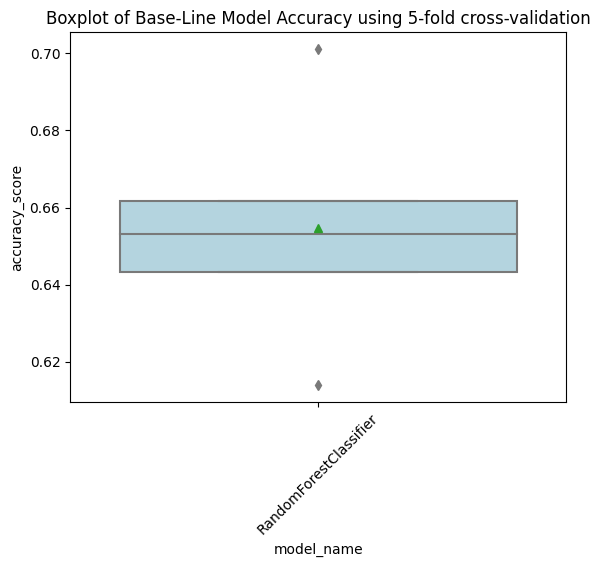

,Mean,Standard Deviation
model_name,,
RandomForestClassifier,0.654672,0.031595


In [29]:
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
def generate_baseline_results(models, X, y, metrics, cv=5, plot_results=False):
    # define k-fold:
    kfold = StratifiedKFold(cv, shuffle=True, random_state=seed)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_val_score(model, X, y, scoring=metrics, cv=kfold)
        for fold_idx, score in enumerate(scores):
            entries.append((model_name, fold_idx, score))
    
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_id', 'accuracy_score'])
    
    if plot_results:
        sns.boxplot(x='model_name', y='accuracy_score', data=cv_df, color='lightblue', showmeans=True)
        plt.title("Boxplot of Base-Line Model Accuracy using 5-fold cross-validation")
        plt.xticks(rotation=45)
        plt.show()
    
    # Summary result
    mean = cv_df.groupby('model_name')['accuracy_score'].mean()
    std = cv_df.groupby('model_name')['accuracy_score'].std()
    
    baseline_results = pd.concat([mean, std], axis = 1, ignore_index=True)
    baseline_results.columns = ['Mean', 'Standard Deviation']
    
    # sort by accuracy
    baseline_results.sort_values(by=['Mean'], ascending=False, inplace=True)
    
    return baseline_results
    
generate_baseline_results(models, X, y, metrics='accuracy', cv=5, plot_results=True)

In [30]:
matches_rolling = matches_rolling.sort_values(by='date', ascending=False)

In [31]:
train = matches_rolling[matches_rolling["date"] < '2023-03-10']
test = matches_rolling[matches_rolling["date"] > '2023-03-10']
model = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1).fit(train[features], train['target'])

In [32]:
def Predict(team1, team2):
    home_ = test[(test['team'] == team1) & (test['opponent'] == team2)].iloc[0]
    rsl = model.predict([home_[features]])
    if rsl[0] == 1:
        print("Predict: {0} Win against {1}".format(team1, team2))
    else:
        print("Predict: {0} draw or lose against {1}".format(team1, team2))
    return [rsl[0], home_["target"]]

### Predict Liverpool Result From 11/3/2023 - 20/5/2023

In [33]:
opps = list(test[test["team"] == "Liverpool"].sort_values(by='date')["opponent"])
team_ = "Liverpool"

In [34]:
rsls = []
for opp in opps:
    rsl = Predict(team_, opp)
    rsls.append(rsl)

Predict: Liverpool Win against Bournemouth
Predict: Liverpool Win against Manchester City
Predict: Liverpool draw or lose against Chelsea
Predict: Liverpool draw or lose against Arsenal
Predict: Liverpool draw or lose against Leeds United
Predict: Liverpool draw or lose against Nott'ham Forest
Predict: Liverpool Win against West Ham
Predict: Liverpool Win against Tottenham
Predict: Liverpool Win against Fulham
Predict: Liverpool Win against Brentford
Predict: Liverpool Win against Leicester City
Predict: Liverpool Win against Aston Villa


d:\Python\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitte